In [12]:
import os
import sys
import numpy as np
import numpy.typing as npt
from typing import List, Tuple

from helpers.SDEModels import MeanRevertingSDE

In [13]:
import gymnasium as gym
from gymnasium import spaces

In [14]:
class SimulationEnv(gym.Env):    
    def __init__(self):        
        super().__init__()
        import python_modules.Server as Server
        self.Server = Server
        
        self.rng = np.random.default_rng()
        self.SDE = MeanRevertingSDE(self.rng)
        
        self.ORDER_SIZE_MIN = 1
        self.ORDER_SIZE_MAX = 5
        self.REMOVAL_PERCENTAGE = 0.10 # The "liquidity" traders (aka "anon") will cancel this percent of their orders every step
        
        self.currency = Server.GenericSecurities.GenericCurrency("CURRENCY")
        self.stock = Server.GenericSecurities.GenericStock("STOCK", "CURRENCY")
        self.simulation = Server.GenericSimulation({ "CURRENCY": self.currency, "STOCK": self.stock }, 1.0, 1000) 
        self.currency_id = self.simulation.get_security_id("CURRENCY")
        self.stock_id = self.simulation.get_security_id("STOCK")
        
        self.agent_id = self.simulation.add_user("AGENT")
        self.anon_id = self.simulation.add_user("ANON")
        
        self.MAX_POSITION = 20
        
        self.previous_portfolio_value = 0.0
        self._initialize_book()
        self.midpoint_list = [self._get_midpoint()]

        self.action_space = spaces.Discrete(5) # 0 = hold, 1 = buy (1), 2 = buy (2), 3 = sell (1), 4 = sell (2)
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(11,), dtype=np.float32)
        pass

    def _get_midpoint(self) -> float:
        return (self.simulation.get_top_bid(self.stock_id).price + self.simulation.get_top_ask(self.stock_id).price) / 2.0

    def _initialize_book(self):
        t = self.simulation.get_t()
        dt = self.simulation.get_dt()
        ORDER_COUNT = self.SDE.get_order_count(t, dt)
    
        price_distribution = self.rng.uniform(0.75, 1.0, size=ORDER_COUNT)
        volume_distribution = self.rng.integers(self.ORDER_SIZE_MIN, self.ORDER_SIZE_MAX, ORDER_COUNT)
        target = self.SDE.get_stock_price(t, dt)
        volatility = self.SDE.get_volatility(t, dt)
        SPREAD = self.SDE.get_spread(t, dt)
        HALF_SPREAD = SPREAD / 2

        bid_top_price = round(target - HALF_SPREAD, 2)
        bid_bottom_price = round(bid_top_price - 0.5 * volatility * bid_top_price, 2)
        bid_prices: List[float] = list(bid_top_price * price_distribution + bid_bottom_price * (1.0 - price_distribution))
        bids = [(self.Server.OrderSide.BID, price, volume_distribution[i]) for i, price in enumerate(bid_prices)]
        
        ask_bottom_price = round(target + HALF_SPREAD, 2)
        ask_top_price = round(ask_bottom_price + 0.5 * volatility * ask_bottom_price, 2)
        ask_prices: List[float] = list(ask_bottom_price * price_distribution + ask_top_price * (1.0 - price_distribution))
        asks = [(self.Server.OrderSide.ASK, price, volume_distribution[i]) for i, price in enumerate(ask_prices)]

        combined_orders = bids + asks
        self.rng.shuffle(combined_orders)

        for (side, price, volume) in combined_orders:
            self.simulation.direct_insert_limit_order(self.anon_id, self.stock_id, side, round(price, 2), volume)
            pass
        pass
    
    def _do_liquidity_trading(self):
        t = self.simulation.get_t()
        dt = self.simulation.get_dt()
        ORDER_COUNT = self.SDE.get_order_count(t, dt)
        orders_ANON = list(self.simulation.get_all_open_user_orders(self.anon_id, self.stock_id))
        
        # remove some percent of ANON orders
        if (k := int(len(orders_ANON) * self.REMOVAL_PERCENTAGE)) > 0:
            orders_to_remove = list(self.rng.choice(a=orders_ANON, size=k, replace=False))
            for order_id in orders_to_remove:
                self.simulation.submit_cancel_order(self.anon_id, self.stock_id, order_id)
                pass
            pass
        
        top_bid = self.simulation.get_top_bid(self.stock_id)
        top_ask = self.simulation.get_top_ask(self.stock_id)
        
        top_bid_price = top_bid.price
        top_ask_price = top_ask.price
        
        bid_prices = self.SDE.generate_bid_price_array(top_bid_price, t, dt)
        bid_quantities = self.rng.integers(self.ORDER_SIZE_MIN, self.ORDER_SIZE_MAX, size=ORDER_COUNT)
        bids = [(self.Server.OrderSide.BID, price, bid_quantities[i]) for i, price in enumerate(bid_prices)]
        
        ask_prices = self.SDE.generate_ask_price_array(top_ask_price, t, dt)
        ask_quantities = self.rng.integers(self.ORDER_SIZE_MIN, self.ORDER_SIZE_MAX, size=ORDER_COUNT) 
        asks = [(self.Server.OrderSide.ASK, price, ask_quantities[i]) for i, price in enumerate(ask_prices)]
        
        combined_orders = bids + asks
        self.rng.shuffle(combined_orders)

        for (side, price, volume) in combined_orders:
            self.simulation.submit_limit_order(self.anon_id, self.stock_id, side, round(price, 2), volume)
            pass
        pass
    
    def _get_portfolio_value(self):
        portfolio = self.simulation.get_user_portfolio(self.agent_id)
        stock_pos = portfolio[self.stock_id]
        currency_pos = portfolio[self.currency_id]
        top_bid = self.simulation.get_top_bid(self.stock_id).price
        top_ask = self.simulation.get_top_ask(self.stock_id).price
        stock_value = stock_pos * (top_bid if stock_pos < 0 else top_ask)
        return currency_pos + stock_value

    def reset(self, seed=None, options=None):
        self.simulation.reset_simulation()
        self.previous_portfolio_value = 0.0
        self._initialize_book()
        self.midpoint_list = [self._get_midpoint()]
        obs = self._get_obs()
        return obs, {}

    def step(self, action):       
        # Cancel any previous agent orders if applicable
        tick = self.simulation.get_tick()
        agent_portfolio = self.simulation.get_user_portfolio(self.agent_id)
        agent_stock_position = agent_portfolio[self.stock_id]
        
        # The agent always gets to go first  
        match action:
            case 0:
                # Do nothing
                pass
            case 1:
                # Buy (1)
                if agent_stock_position + 1 <= self.MAX_POSITION:
                    self.simulation.submit_market_order(self.agent_id, self.stock_id, self.Server.OrderAction.BUY, 1)
                pass
            case 2:
                # Buy (2)
                if agent_stock_position + 2 <= self.MAX_POSITION:
                    self.simulation.submit_market_order(self.agent_id, self.stock_id, self.Server.OrderAction.BUY, 2)
                pass
            case 3:
                # Sell (1)
                if agent_stock_position - 1 >= -self.MAX_POSITION:
                    self.simulation.submit_market_order(self.agent_id, self.stock_id, self.Server.OrderAction.SELL, 1)
                pass
            case 4:
                # Sell (2)
                if agent_stock_position - 2 >= -self.MAX_POSITION:
                    self.simulation.submit_market_order(self.agent_id, self.stock_id, self.Server.OrderAction.SELL, 2)
                pass
            case _:
                # Unknown...
                pass
        
        # Enter liquidity orders
        # We already initialize the book on tick == 0 (look at reset and __init__)
        if tick != 0:
            self._do_liquidity_trading()
            pass

        result = self.simulation.do_simulation_step()
        
        # market positions to market
        # On the last step, the the `Server` library automatically converts the remaining stock position into currency        
        portfolio_value = self._get_portfolio_value()
        
        # Compute reward as change in portfolio value
        risk_penalty = 0.005 * abs(agent_stock_position)
        reward = portfolio_value - self.previous_portfolio_value
        reward -= risk_penalty
        reward = np.clip(reward, -10.0, 10.0)
        
        terminated = not result.has_next_step
        obs = self._get_obs()
        self.previous_portfolio_value = portfolio_value
        self.midpoint_list.append(self._get_midpoint())
        return obs, reward, terminated, False, {}
    
    def _get_obs(self):
        top_bid_price = self.simulation.get_top_bid(self.stock_id).price
        top_ask_price = self.simulation.get_top_ask(self.stock_id).price
        mid_price = 0.5 * (top_bid_price + top_ask_price)
        stock_position = self.simulation.get_user_portfolio(self.agent_id)[self.stock_id]
        max_tick = self.simulation.get_N()
        tick = self.simulation.get_tick()
        
        price_mavg_5 = np.mean(self.midpoint_list[-5:])
        price_mavg_20 = np.mean(self.midpoint_list[-20:])
        price_std_5 = np.std(self.midpoint_list[-5:])
        price_std_20 = np.std(self.midpoint_list[-20:])

        return np.array([
            top_bid_price,
            top_ask_price,
            mid_price,
            stock_position,
            mid_price - self.midpoint_list[-1],
            mid_price - 100.0,
            mid_price - price_mavg_5,
            mid_price - price_mavg_20,
            price_std_5,
            price_std_20,
            (max_tick - tick) / max_tick,
        ], dtype=np.float32)

In [15]:
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import SubprocVecEnv, DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import CheckpointCallback

In [16]:
def make_env():
    def _init():
        env = SimulationEnv()
        return Monitor(env)  # for logging
    return _init

env = SubprocVecEnv([make_env() for _ in range(8)])

policy_kwargs = dict(net_arch=[64, 64])
model = PPO("MlpPolicy", 
    env, 
    verbose=0, 
    policy_kwargs=policy_kwargs, 
    device="cpu",
    tensorboard_log="./tensorboard_logs/"
)
model.learn(total_timesteps=1_000_000)

# Save model
model.save("gymnasium_v03_model")

In [17]:
import matplotlib.pyplot as plt

def evaluate_agent(model, env: SimulationEnv):
    obs, _ = env.reset()
    done = False

    mid_prices = []
    stock_positions = []
    currency_positions = []
    portfolio_values = []
    rewards = []
    ticks = []

    while not done:
        action, _ = model.predict(obs)
        obs, reward, done, truncated, info = env.step(action)
        rewards.append(reward)
        
        tick = env.simulation.get_tick()
        ticks.append(tick)

        # Record values
        bid = env.simulation.get_top_bid(env.stock_id).price
        ask = env.simulation.get_top_ask(env.stock_id).price
        mid = 0.5 * (bid + ask)
        mid_prices.append(mid)

        portfolio = env.simulation.get_user_portfolio(env.agent_id)
        stock_pos = portfolio[env.stock_id]
        currency_pos = portfolio[env.currency_id]
        stock_value = stock_pos * (bid if stock_pos < 0 else ask)
        total_value = currency_pos + stock_value

        stock_positions.append(stock_pos)
        currency_positions.append(currency_pos)
        portfolio_values.append(total_value)

    print(f"Final portfolio value: {total_value:.2f}")

    # Plotting
    fig, axs = plt.subplots(5, 1, figsize=(12, 10), sharex=True)

    axs[0].plot(ticks, mid_prices, color="blue")
    axs[0].set_ylabel("Mid Price")
    axs[0].grid()

    axs[1].plot(ticks, stock_positions, color="green")
    axs[1].set_ylabel("Agent Stock Position")
    axs[1].grid()

    axs[2].plot(ticks, currency_positions, color="orange")
    axs[2].set_ylabel("Agent Currency Position")
    axs[2].grid()

    axs[3].plot(ticks, portfolio_values, color="purple")
    axs[3].set_ylabel("Agent Portfolio Value")
    axs[3].set_xlabel("Tick")
    axs[3].grid()
    
    axs[4].plot(ticks, rewards, color="red")
    axs[4].set_ylabel("Reward Value")
    axs[4].set_xlabel("Tick")
    axs[4].grid()

    plt.tight_layout()
    plt.show()


Final portfolio value: 53.48


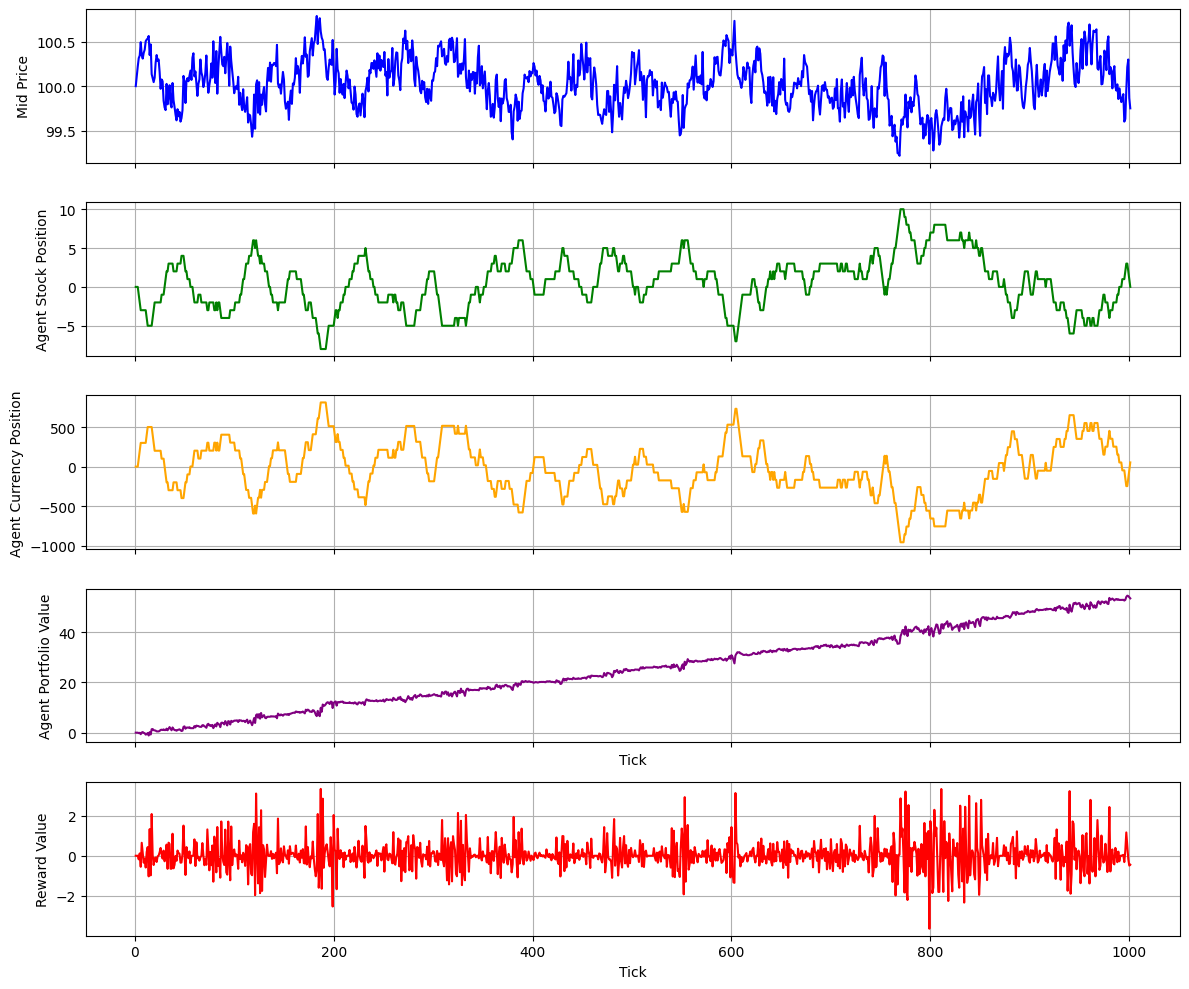

In [22]:
evaluate_agent(model, SimulationEnv())